# Tugas Pemodelan, Simulasi, dan Optimisasi
## Model Pergerakan Harga Saham Binomial (Monte Carlo)

**Sektor:** Keuangan (Bank Central Asia)
**Data:** 18 Bulan (12 Bulan Training, 6 Bulan Testing)

### 1. Identifikasi Masalah & Teori

Memprediksi pergerakan harga saham menggunakan model **Binomial Tree** dan simulasi **Monte Carlo**.

**Model Binomial:**
$$S(n) = S_0 u^x d^{n-x}$$

**Parameterisasi:**
1.  **Metode CRR (Cox, Ross, Rubinstein):**
    $$u = e^{\sigma\sqrt{\Delta t}}, \quad d = e^{-\sigma\sqrt{\Delta t}}, \quad p = \frac{e^{r\Delta t} - d}{u - d}$$
2.  **Metode Empiris:**
    Dihitung dari rata-rata return historis positif ($u$) dan negatif ($d$).

**Metrik Evaluasi:**
* **MAE**: $\frac{1}{n} \sum |y - \hat{y}|$
* **MAPE**: $\frac{1}{n} \sum |\frac{y - \hat{y}}{y}|$
* **RMSE**: $\sqrt{\frac{1}{n} \sum (y - \hat{y})^2}$

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import norm

plt.style.use('seaborn-v0_8-whitegrid')

### 2. Persiapan Data

In [22]:
ticker = "BBCA.JK"
file_name = "bbca_data.csv"
start = "2024-06-19"
end   = "2025-12-19"

try:
    df = yf.download(ticker, start=start, end=end, progress=False, timeout=20)
    if isinstance(df.columns, pd.MultiIndex):
        df = df.xs(ticker, axis=1, level=1, drop_level=True)
    if df.empty or len(df) < 10:
        raise ValueError
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df.to_csv(file_name)
except:
    dates = pd.date_range(start=start, end=end, freq='B')
    np.random.seed(42)
    rets = np.random.normal(0.0005, 0.012, len(dates))
    prices = 9000 * np.cumprod(1 + rets)
    df = pd.DataFrame({'Close': prices}, index=dates)
    df.to_csv(file_name)

/tmp/ipython-input-1047134502.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False, timeout=20)


### 3. Load Data & Splitting

Membagi data menjadi:
* **Training (12 Bulan):** Estimasi parameter.
* **Testing (6 Bulan):** Validasi model.

Total: 365
Training: 240
Testing: 125


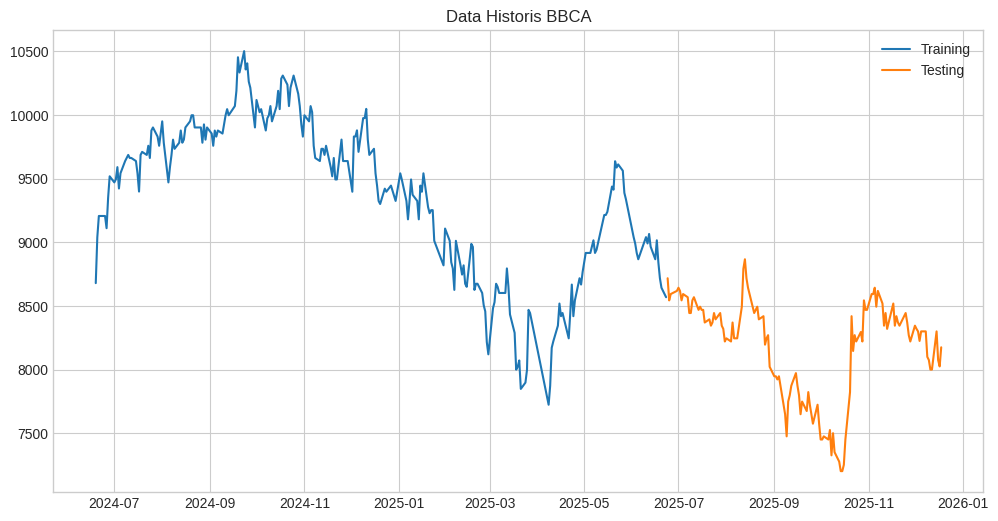

In [23]:
df = pd.read_csv("bbca_data.csv", index_col=0, parse_dates=True)
prices = df['Close']

splitidx = int(len(prices) * (2/3))
train_data = prices.iloc[:split_idx]
test_data = prices.iloc[split_idx:]

print(f"Total: {len(prices)}")
print(f"Training: {len(train_data)}")
print(f"Testing: {len(test_data)}")

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Testing')
plt.title('Data Historis BBCA')
plt.legend()
plt.show()

### 4. Estimasi Parameter ($u, d, p$)

Menghitung parameter model CRR dan Empiris berdasarkan data Training, serta visualisasi distribusi return.

In [24]:
r = 0.06
T = 1
N_days = 252
dt = T / N_days

log_rets = np.log(train_data / train_data.shift(1)).dropna()
sigma = log_rets.std() * np.sqrt(N_days)

u_crr = np.exp(sigma * np.sqrt(dt))
d_crr = np.exp(-sigma * np.sqrt(dt))
p_crr = (np.exp(r * dt) - d_crr) / (u_crr - d_crr)

daily_rets = train_data / train_data.shift(1)
daily_rets = daily_rets.dropna()

ret_up = daily_rets[daily_rets >= 1]
ret_down = daily_rets[daily_rets < 1]

u_emp = ret_up.mean()
d_emp = ret_down.mean()
p_emp = len(ret_up) / len(daily_rets)

print(f"CRR: u={u_crr:.5f}, d={d_crr:.5f}, p={p_crr:.5f}, sigma={sigma:.5f}")
print(f"Empiris: u={u_emp:.5f}, d={d_emp:.5f}, p={p_emp:.5f}")

CRR: u=1.01703, d=0.98325, p=0.50283, sigma=0.26809
Empiris: u=1.01222, d=0.98701, p=0.51883


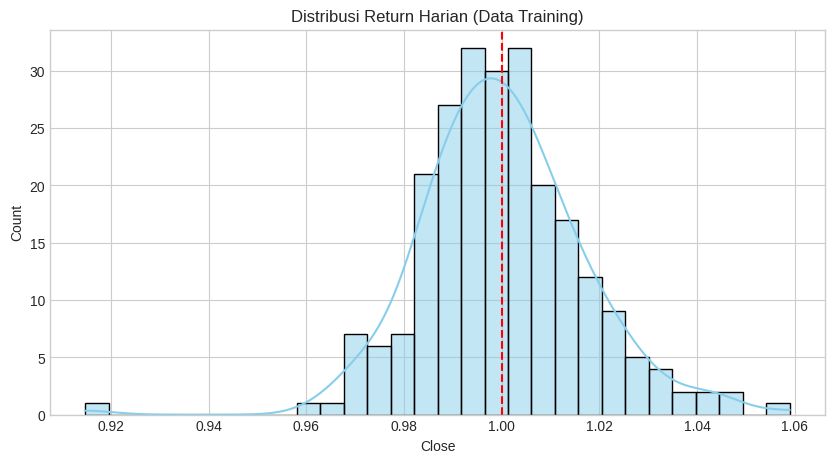

In [25]:
plt.figure(figsize=(10, 5))
sns.histplot(daily_rets, bins=30, kde=True, color='skyblue')
plt.axvline(daily_rets.mean(), color='red', linestyle='--')
plt.title('Distribusi Return Harian (Data Training)')
plt.show()

### 5. Simulasi Monte Carlo

Simulasi pergerakan harga untuk periode testing (Spaghetti Plot).

In [26]:
def run_monte_carlo(S0, u, d, p, N_steps, M_sims):
    paths = np.zeros((M_sims, N_steps + 1))
    paths[:, 0] = S0

    for i in range(M_sims):
        rands = np.random.rand(N_steps)
        ups_downs = np.where(rands < p, u, d)
        paths[i, 1:] = S0 * np.cumprod(ups_downs)

    mean_path = np.mean(paths, axis=0)
    std_path = np.std(paths, axis=0)
    se_path = std_path / np.sqrt(M_sims)

    ci_lower = mean_path - 1.96 * se_path
    ci_upper = mean_path + 1.96 * se_path

    return mean_path, ci_lower, ci_upper, paths

S0_test = float(train_data.iloc[-1])
N_test = len(test_data)
M_sims = 1000

mu_crr, lb_crr, ub_crr, paths_crr = run_monte_carlo(S0_test, u_crr, d_crr, p_crr, N_test, M_sims)
mu_emp, lb_emp, ub_emp, paths_emp = run_monte_carlo(S0_test, u_emp, d_emp, p_emp, N_test, M_sims)

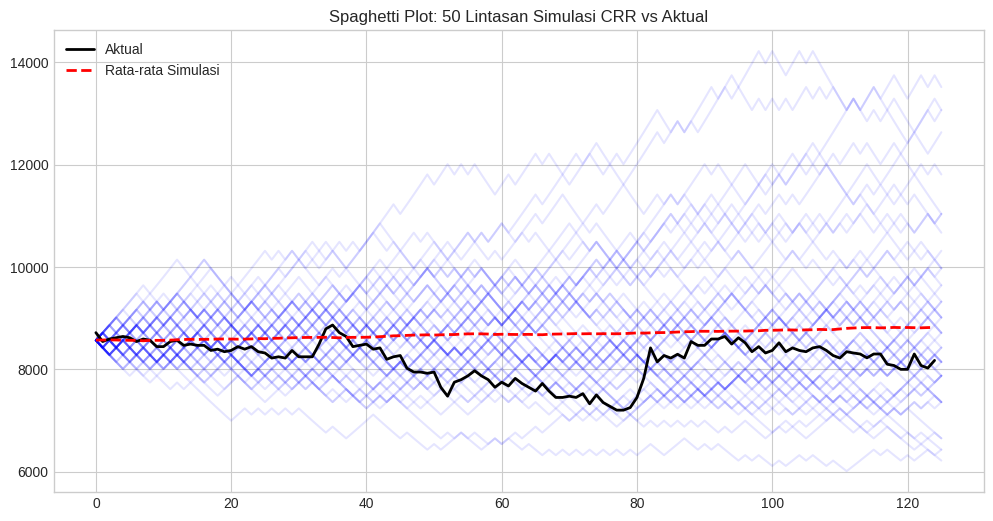

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(paths_crr[:50].T, color='blue', alpha=0.1)
plt.plot(test_data.values, color='black', linewidth=2, label='Aktual')
plt.plot(mu_crr[1:], color='red', linestyle='--', linewidth=2, label='Rata-rata Simulasi')
plt.title('Spaghetti Plot: 50 Lintasan Simulasi CRR vs Aktual')
plt.legend()
plt.show()

### 6. Evaluasi Error

Menghitung akurasi model (MAE, MAPE, RMSE) terhadap data aktual.

In [28]:
actual = test_data.values
error_crr = actual - mu_crr[1:]
error_emp = actual - mu_emp[1:]

def get_metrics(act, pred):
    mae = np.mean(np.abs(act - pred))
    mape = np.mean(np.abs((act - pred) / act)) * 100
    rmse = np.sqrt(np.mean((act - pred) ** 2))
    return mae, mape, rmse

mae_c, mape_c, rmse_c = get_metrics(actual, mu_crr[1:])
mae_e, mape_e, rmse_e = get_metrics(actual, mu_emp[1:])

results = pd.DataFrame({
    'Metric': ['MAE', 'MAPE (%)', 'RMSE'],
    'CRR': [mae_c, mape_c, rmse_c],
    'Empiris': [mae_e, mape_e, rmse_e]
})
print(results)

     Metric         CRR     Empiris
0       MAE  522.269792  448.176529
1  MAPE (%)    6.644439    5.728490
2      RMSE  657.953399  589.761877


### 7. Visualisasi Hasil & Distribusi Error

Membandingkan hasil prediksi rata-rata kedua model dengan harga aktual, serta analisis distribusi error.

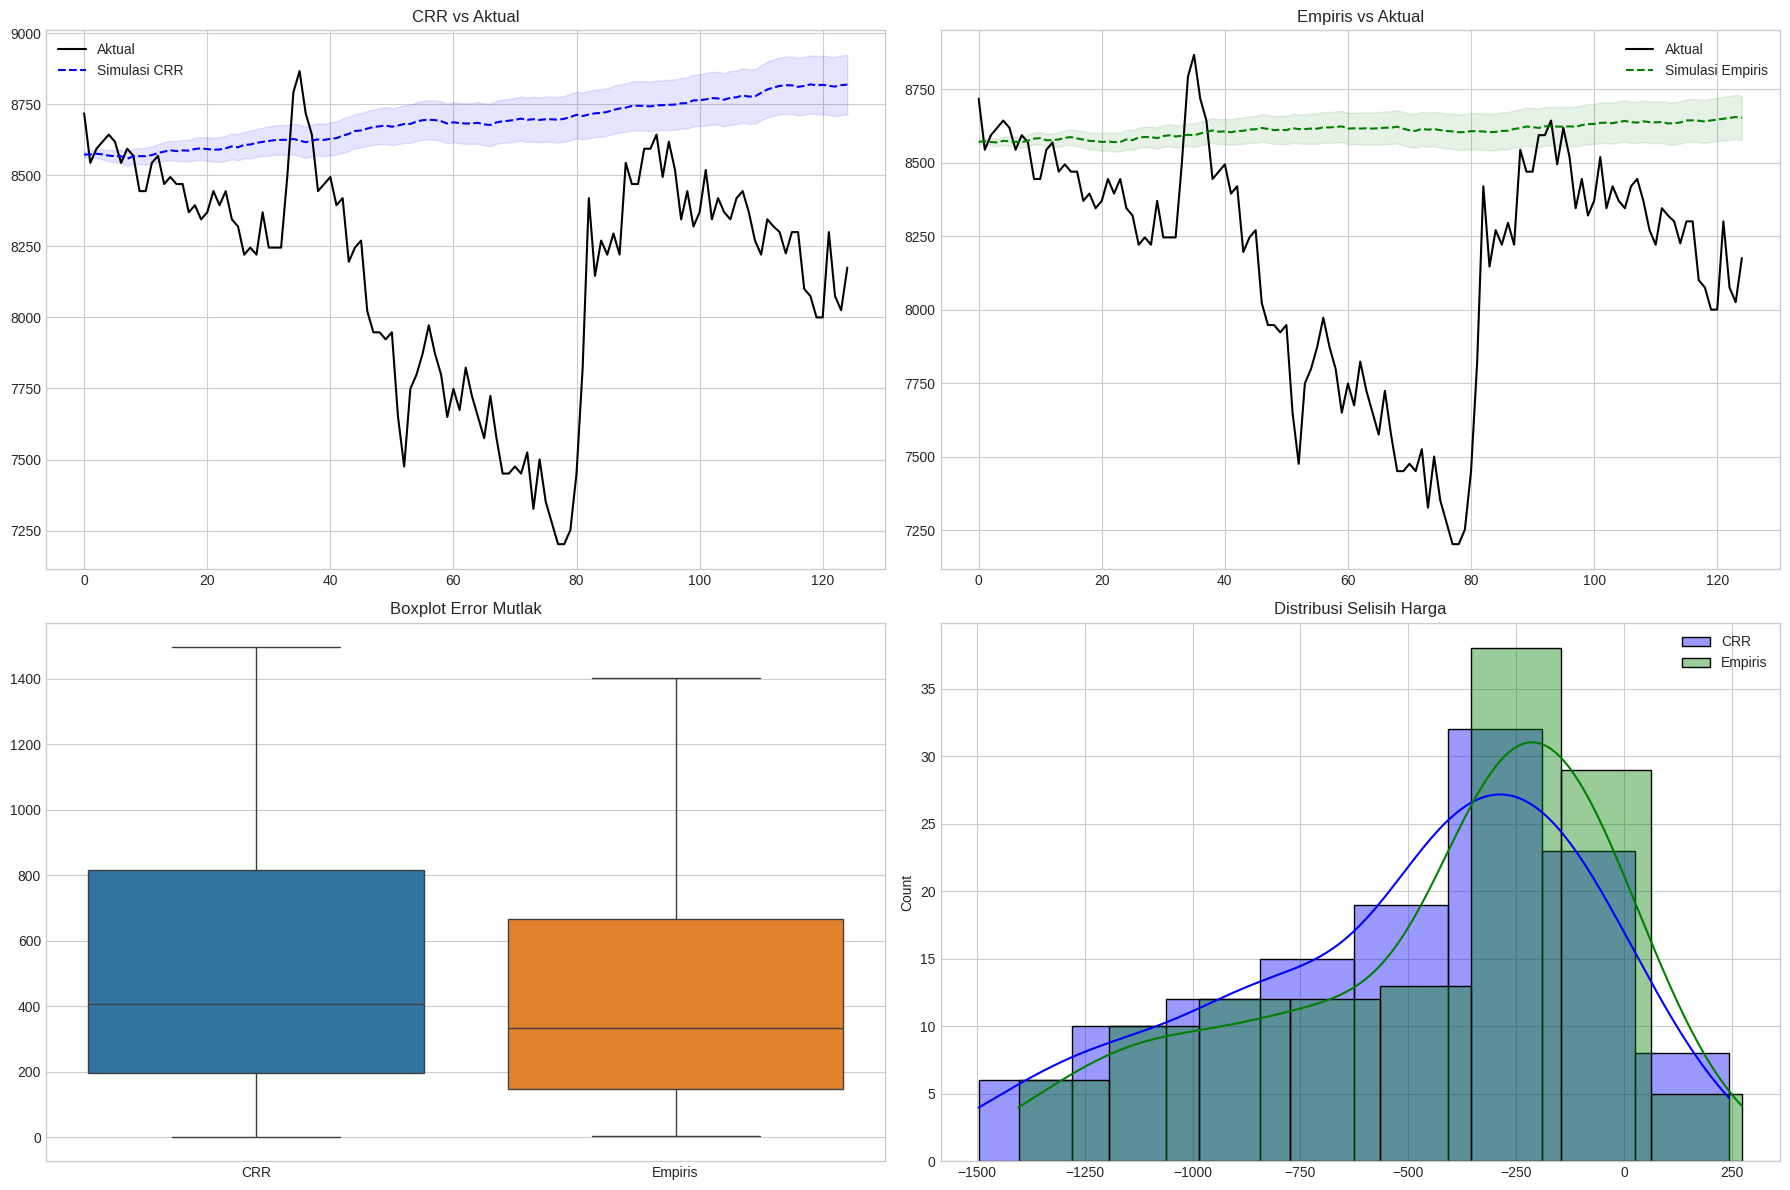

In [29]:
days = np.arange(N_test)
fig, ax = plt.subplots(2, 2, figsize=(18, 12))

ax[0, 0].plot(actual, 'k-', label='Aktual')
ax[0, 0].plot(mu_crr[1:], 'b--', label='Simulasi CRR')
ax[0, 0].fill_between(days, lb_crr[1:], ub_crr[1:], color='blue', alpha=0.1)
ax[0, 0].set_title('CRR vs Aktual')
ax[0, 0].legend()

ax[0, 1].plot(actual, 'k-', label='Aktual')
ax[0, 1].plot(mu_emp[1:], 'g--', label='Simulasi Empiris')
ax[0, 1].fill_between(days, lb_emp[1:], ub_emp[1:], color='green', alpha=0.1)
ax[0, 1].set_title('Empiris vs Aktual')
ax[0, 1].legend()

sns.boxplot(data=pd.DataFrame({'CRR': np.abs(error_crr), 'Empiris': np.abs(error_emp)}), ax=ax[1, 0])
ax[1, 0].set_title('Boxplot Error Mutlak')

sns.histplot(error_crr, color='blue', kde=True, ax=ax[1, 1], label='CRR', alpha=0.4)
sns.histplot(error_emp, color='green', kde=True, ax=ax[1, 1], label='Empiris', alpha=0.4)
ax[1, 1].set_title('Distribusi Selisih Harga')
ax[1, 1].legend()

plt.tight_layout()
plt.show()